# Basics of Deep Learning

In [2]:
student_id = 400100554 #@param {type:"integer"}
student_name = "Seyed Mohammad Ojagh Kazzazi" #@param {type:"string"}

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook).

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# TODO: Enter the foldername in your Drive where you have saved the
# assignment files, e.g. 'DL/assignments/assignment1/'
FOLDERNAME = "DL_HW1_Q3"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

The dataset for this exercise is CIFAR-10. Let's first download it then we'll explore it.

In [5]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/DL_HW1_Q3/datasets
/content/drive/My Drive/DL_HW1_Q3


In [6]:
import os
import pytz
from datetime import datetime

# The file path
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
pytorch_path = os.path.join(GOOGLE_DRIVE_PATH, 'k_nearest_neighbor.py')

# Get the last modified time in UTC
last_modified_time = os.path.getmtime(pytorch_path)
utc_time = datetime.utcfromtimestamp(last_modified_time)

# Define Iran's time zone
iran_tz = pytz.timezone('Asia/Tehran')

# Convert UTC time to Iran time
iran_time = pytz.utc.localize(utc_time).astimezone(iran_tz)

# Print the result in Iran's local time
print(f"k_nearest_neighbor.py last edited on: {iran_time.strftime('%Y-%m-%d %H:%M:%S')}")

k_nearest_neighbor.py last edited on: 2024-10-26 16:15:25


# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

You will implement these steps in this notebook and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

The following code is to setup the enviroment

In [7]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is here so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [9]:
################################################################################
# TODO:                                                                        #
# As a sanity check, print out the size of the training and test data and      #
# also the size of their labels                                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")
print(f"Training labels size: {y_train.shape}")
print(f"Test labels size: {y_test.shape}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Training data size: (50000, 32, 32, 3)
Test data size: (10000, 32, 32, 3)
Training labels size: (50000,)
Test labels size: (10000,)


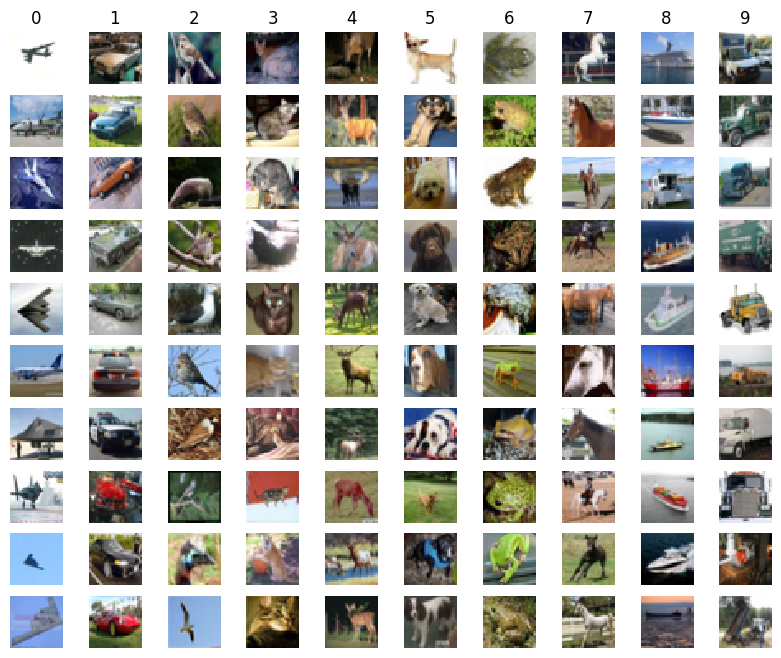

In [10]:
classes = []
num_classes = None
samples_per_class = 10

################################################################################
# TODO:                                                                        #
# Explore the dataset and find its classes. Then visualize some examples.      #
# To do so show a few examples of training images from each class              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# Assuming X_train is your training data and y_train are the labels
classes = np.unique(y_train)
num_classes = len(classes)

# Plot samples_per_class examples from each class
for cls in classes:
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:  # Only set title for the first column
            plt.title(cls)

plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [11]:
################################################################################
# TODO:                                                                        #
# Subsample the data for more efficient code execution in this exercise.       #
# You should reduce the number of training and test examples used.             #
# Set num_training to 5000 and num_test to 500.                                #
# Reshape the image data into rows to prepare for processing.                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


num_training = 5000
num_test = 500

# Subsample the data
X_train_sub = X_train[:num_training]
y_train_sub = y_train[:num_training]
X_test_sub = X_test[:num_test]
y_test_sub = y_test[:num_test]

# Reshape the image data into rows
X_train_sub = X_train_sub.reshape(num_training, -1)
X_test_sub = X_test_sub.reshape(num_test, -1)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [12]:
from k_nearest_neighbor import KNearestNeighbor

################################################################################
# TODO:                                                                        #
# Create a kNN classifier instance and call its training method.                #
# Remember that training a kNN classifier is a noop:                           #
# the classifier simply remembers the data and does no further processing.     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Create a kNN classifier instance
knn = KNearestNeighbor()

# Train the classifier (this is a noop)
knn.train(X_train_sub, y_train_sub)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [13]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# TODO: Test your implementation:
dists = knn.compute_distances_two_loops(X_test_sub)
print(dists.shape)

(500, 5000)


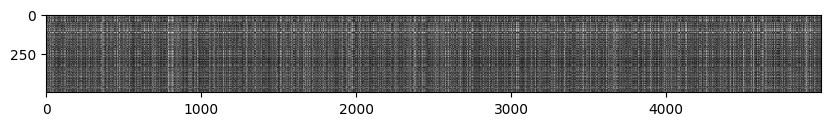

In [14]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [15]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = knn.predict_labels(dists, k=1)

# TODO: Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test_sub)
accuracy = num_correct / num_test
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

137 / 500 were correct => accuracy: 0.274000


**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{pink}{\textit Your Answer:}$


***Bright Rows***

- Cause: Bright rows in the distance matrix indicate that the corresponding test samples have high distances to all training samples.

- Reason: This can happen if the test samples are outliers or significantly different from the training samples. For example, if a test sample has features that are not well-represented in the training data, it will have high distances to all training samples.

***Bright Columns***

- Cause: Bright columns in the distance matrix indicate that the corresponding training samples have high distances to all test samples.

- Reason: This can happen if the training samples are outliers or significantly different from the test samples. For example, if a training sample has features that are not well-represented in the test data, it will have high distances to all test samples.



You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [16]:
# Predict labels using k=5
y_test_pred = knn.predict_labels(dists, k=5)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test_sub)
accuracy = num_correct / num_test
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

139 / 500 were correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [17]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = knn.compute_distances_one_loop(X_test_sub)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [18]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = knn.compute_distances_no_loops(X_test_sub)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{pink}{\textit Your Answer:}$

3,4, and 5


$\color{pink}{\textit Your Explanation:}$

#### L1 Distance
L1 distance (Manhattan distance) between two vectors $( \mathbf{x} )$ and $( \mathbf{y} )$ is defined as:
$ \text{L_1 distance} = \sum_{i} |x_i - y_i| $

#### Preprocessing Steps

1. **Subtracting the mean $( \mu )$**
   - **Effect**: This step centers the data around zero by subtracting the overall mean.
   - **Impact on L1 Distance**: L1 distance is translation invariant, meaning that subtracting a constant from all elements does not change the relative distances between points.
   - **Conclusion**: This will not change the performance.

2. **Subtracting the per pixel mean $( \mu_{ij} )$**
   - **Effect**: This step centers each pixel value around its own mean.
   - **Impact on L1 Distance**: Similar to the first step, this is a translation of each pixel value and does not affect the relative distances.
   - **Conclusion**: This will not change the performance.

3. **Subtracting the mean $( \mu )$ and dividing by the standard deviation $( \sigma )$**
   - **Effect**: This step standardizes the data to have zero mean and unit variance.
   - **Impact on L1 Distance**: Dividing by the standard deviation changes the scale of the data, which affects the L1 distance.
   - **Conclusion**: This will change the performance.

4. **Subtracting the pixel-wise mean $( \mu_{ij} )$ and dividing by the pixel-wise standard deviation $( \sigma_{ij} )$**
   - **Effect**: This step standardizes each pixel value to have zero mean and unit variance.
   - **Impact on L1 Distance**: Similar to the third step, this changes the scale of the data, affecting the L1 distance.
   - **Conclusion**: This will change the performance.

5. **Rotating the coordinate axes of the data**
   - **Effect**: This step rotates all images by the same angle.
   - **Impact on L1 Distance**: Rotation changes the relative positions of the pixels, which affects the L1 distance.
   - **Conclusion**: This will change the performance.



Explain how you have implemented compute_distances_no_loops

$\color{pink}{\textit Your Answer:}$


The compute_distances_no_loops function calculates the L2 distances between each test point and each training point without using explicit loops. Here's a step-by-step explanation of how it works:

1. ***Reshape the Input Matrices:***

    - The input matrices X (test data) and self.X_train (training data) are reshaped to 2D arrays to facilitate matrix operations.

2. ***Compute the Distance Matrix:***

    - The L2 distance between two points ( \mathbf{x} ) and ( \mathbf{y} ) can be expressed as: $ | \mathbf{x} - \mathbf{y} |^2 = | \mathbf{x} |^2 + | \mathbf{y} |^2 - 2 \mathbf{x} \cdot \mathbf{y}$
    - Using this formula, the distance matrix is computed in a fully vectorized manner.

    - Explanation of Each Term:
        - np.dot(X_flat, X_train_flat.T): Computes the dot product between each test point and each training point.
        - np.sum(X_train_flat ** 2, axis=1): Computes the squared L2 norm of each training point.
        - np.sum(X_flat ** 2, axis=1)[:, np.newaxis]: Computes the squared L2 norm of each test point and reshapes it for broadcasting.


3. ***Return the Distance Matrix:***

    - The resulting dists matrix contains the L2 distances between each test point and each training point.




In [19]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(knn.compute_distances_two_loops, X_test_sub)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(knn.compute_distances_one_loop, X_test_sub)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(knn.compute_distances_no_loops, X_test_sub)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 29.552085 seconds
One loop version took 32.629363 seconds
No loop version took 0.374724 seconds


In [20]:
import numpy as np

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# Split up the training data into folds
X_train_folds = np.array_split(X_train_sub, num_folds)
y_train_folds = np.array_split(y_train_sub, num_folds)

# A dictionary holding the accuracies for different values of k
k_to_accuracies = {}

# Perform k-fold cross-validation to find the best value of k
for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # Prepare validation and training data
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        X_train_fold = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_fold = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])

        # Train the k-nearest-neighbor classifier
        knn = KNearestNeighbor()
        knn.train(X_train_fold, y_train_fold)

        # Predict labels for the validation set
        y_val_pred = knn.predict(X_val_fold, k=k)

        # Compute the accuracy
        accuracy = np.mean(y_val_pred == y_val_fold)
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

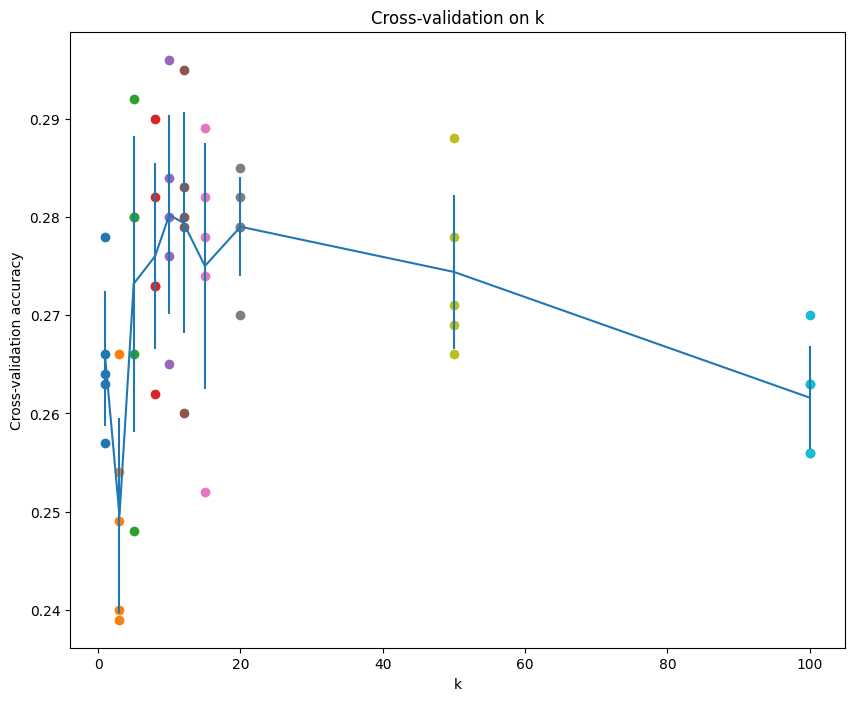

In [21]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [23]:
# TODO: Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
# Based on the cross-validation results above, choose the best value for k
best_k = max(k_to_accuracies, key=lambda k: np.mean(k_to_accuracies[k]))

# Retrain the classifier using all the training data
knn = KNearestNeighbor()
knn.train(X_train_sub, y_train_sub)

# Test the classifier on the test data
y_test_pred = knn.predict(X_test_sub, k=best_k)

# Compute the accuracy
num_correct = np.sum(y_test_pred == y_test_sub)
num_test = X_test_sub.shape[0]
accuracy = num_correct / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

141 / 500 were correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{pink}{\textit Your Answer:}$

2 and 4 are correct.

$\color{pink}{\textit Your Explanation:}$

1. **The decision boundary of the k-NN classifier is linear.**
   - **False**: The decision boundary of a k-NN classifier is generally non-linear, as it depends on the distribution of the training data and the value of \( k \).

2. **The training error of a 1-NN will always be lower than or equal to that of 5-NN.**
   - **True**: In 1-NN, each training example is its own nearest neighbor, so the training error is zero. For 5-NN, the training error can be higher because the prediction is based on the majority vote of the 5 nearest neighbors, which may include misclassifications.

3. **The test error of a 1-NN will always be lower than that of a 5-NN.**
   - **False**: While 1-NN has zero training error, it is more prone to overfitting and may have higher test error compared to 5-NN, which can generalize better by considering multiple neighbors.

4. **The time needed to classify a test example with the k-NN classifier grows with the size of the training set.**
   - **True**: The classification time for k-NN grows linearly with the size of the training set because it requires computing the distance from the test example to all training examples.

5. **None of the above.**
   - **False**: Statements 2 and 4 are true.


